# CAM(Class Activation Map) 모델 구현 및 평가

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 U-Net 모델과 U-Net++ 모델의 성능 비교를 수행합니다. 모델 성능 비교를 위해 각 모델의 손실값과 IoU 값을 확인합니다. 모델 학습 데이터로는 도로 이미지와 세그멘테이션된 이미지로 구성된 KITTI 데이터셋을 사용합니다. 다음은 본 예제의 목차를 제시한 것입니다.
</span><br><br>

> _1. 데이터셋 생성_
>
> _2. 데이터 전처리 및 데이터 증강_
>
> _3. 모델 생성 및 학습_
>
> _4. 모델 평가_

<br><br>

_**<span style="color:red">※본 예제는 LMS 클라우드가 아닌 로컬에서 진행되어 학습 속도 및 결과 등이 상이할 수 있습니다.</span>**_
***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리 호출
***

In [1]:
import tensorflow as tf
from tensorflow import keras as K
import tensorflow_datasets as tfds

import os
import cv2
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
EPOCH = 5
BATCH_SIZE = 16

<br>

## 2. 데이터셋 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 학습하기 이전에 주어진 데이터를 분석하고자 합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다.
</span><br><br>
    
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용하는 데이터는 KITTI 데이터셋의 세그멘테이션 데이터셋 입니다. 분석 결과 입력 데이터는 0에서 255 사이의 int8 형식의 도로 이미지와 객체가 세그멘테이션된 이미지로 구성되어있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 네트워크 학습 전, 데이터셋을 네트워크에 입력 가능한 크기로 변경하는 데이터 전처리를 수행합니다. 'KITTI' 데이터셋의 경우, 입력 데이터인 이미지의 크기가 상이하기 때문에, 모든 이미지 크기를 224 × 224로 리사이즈 해주었습니다.
</span>

***

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

============================================<DATA INFO>=============================================
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})



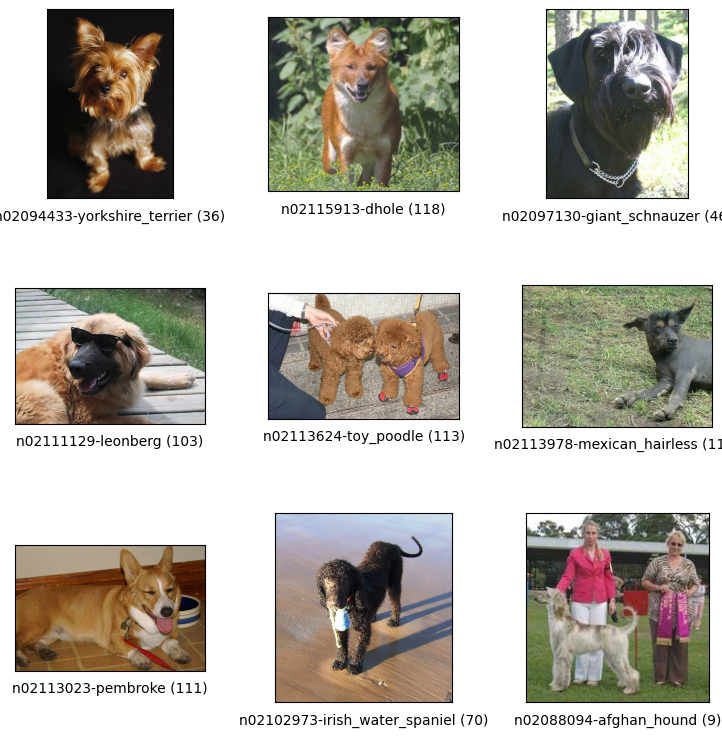

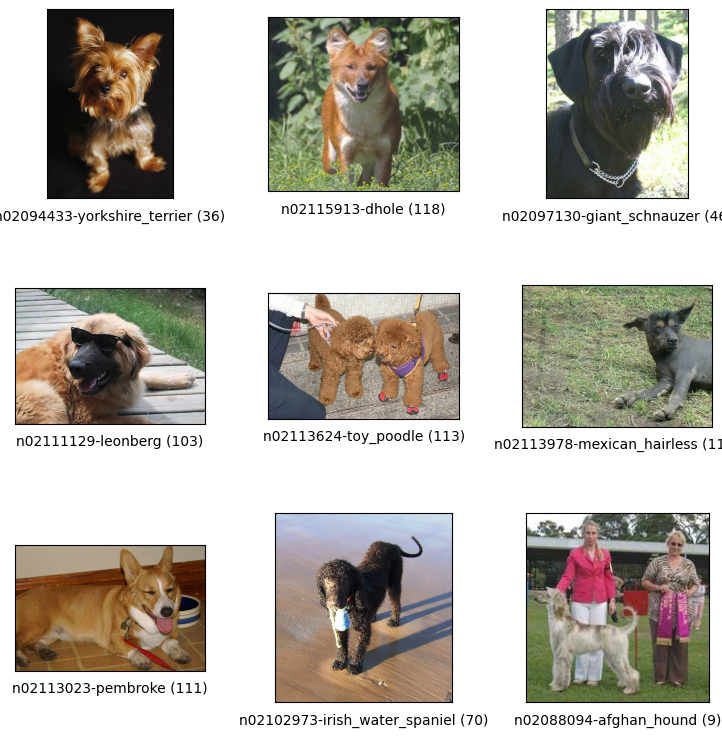

In [4]:
print(f'<DATA INFO>'.center(100, '='))
print(ds_info.features)
print('=' * 100, end='\n\n')
tfds.show_examples(ds_train, ds_info)

In [5]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224]) #resize to 224 by 224
    input['image'] = tf.cast(image, tf.float32) / 255. #Int To Float and normalize
    return input['image'], input['label']


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
#create Dataset
ds_train_norm = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test_norm  = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)


#Print Batch Info
image, label = next(iter(ds_train_norm.take(1)))
print(f'Image Shape:', image.shape)
print(f'Lable Shape:', label.shape)

Image Shape: (16, 224, 224, 3)
Lable Shape: (16,)


<br>

#### 데이터셋 전처리 함수 정의
***
+ `albumentations`를 이용한 데이터셋 전처리 함수 정의


+ 이미지의 크기를 224 × 224로 리사이즈
***

<br>

#### 데이터셋 정의 및 생성
***
+ 예제에 사용되는 학습 데이터를 불러온다.


+ 학습 데이터 셋과 검증 데이터 셋 생성
***

<br>

#### 데이터셋 샘플 시각화
***
+ KITTI 데이터셋 이미지 시각화

***

<br>

## 3. 모델 구현 및 학습
***

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 'U-Net'과 'U-Net++' 성능을 확인하기 위해, 각 모델의 손실 값을 비교합니다. 손실 함수로 'Binary Cross Entropy' 함수를 이용하였습니다. 학습률 1e-4로 설정하여 'Adam' 옵티마이저를 사용하여 총 100 Epoch 학습하였습니다.
</span>

***

In [7]:
num_classes = ds_info.features["label"].num_classes #-> Int(120)
base_model = K.applications.resnet50.ResNet50(
    include_top=False, #Except Last Layer
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)

#Add Last Layer
x = base_model.output
new_last_layer = K.layers.Dense(num_classes, activation='softmax')(x)
cam_model = K.Model(inputs=base_model.input, outputs=new_last_layer)

In [8]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=K.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [9]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples / BATCH_SIZE),
    epochs=5,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 51s 55ms/step - loss: 2.1931 - accuracy: 0.4521 - val_loss: 3.3158 - val_accuracy: 0.2105
Epoch 2/5
750/750 [==============================] - 40s 54ms/step - loss: 0.7922 - accuracy: 0.7735 - val_loss: 1.2116 - val_accuracy: 0.6517
Epoch 3/5
750/750 [==============================] - 40s 54ms/step - loss: 0.3224 - accuracy: 0.9209 - val_loss: 1.0358 - val_accuracy: 0.7028
Epoch 4/5
750/750 [==============================] - 41s 54ms/step - loss: 0.1317 - accuracy: 0.9762 - val_loss: 0.9588 - val_accuracy: 0.7213
Epoch 5/5
750/750 [==============================] - 41s 55ms/step - loss: 0.0560 - accuracy: 0.9945 - val_loss: 1.0088 - val_accuracy: 0.7108


In [14]:
#Save Model
cam_model_path = f'./model/{EPOCH:04d}.h5'
cam_model.save(cam_model_path)

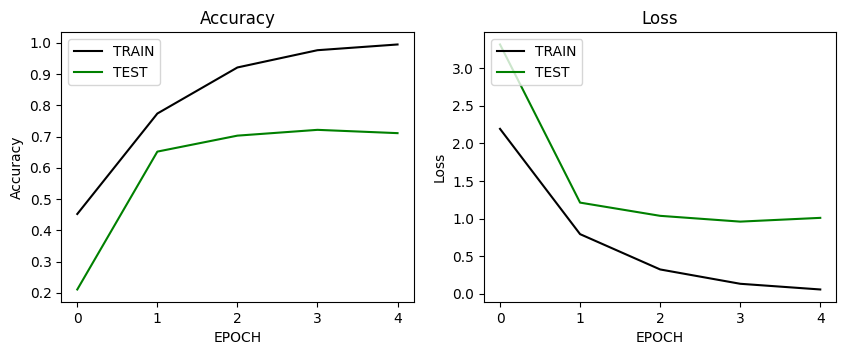

In [34]:
def draw_acc_loss(history):
    def draw_graph(his, sub, ylabel):
        plt.title(ylabel)
        plt.plot(his.history[sub], color='black', label='TRAIN')
        plt.plot(his.history[f'val_{sub}'], color='green', label='TEST')
        plt.xlabel('EPOCH')
        plt.ylabel(ylabel)
        plt.legend(loc='upper left')
    
    plt.figure(figsize=(10, 3.5))
    
    plt.subplot(1, 2, 1)
    draw_graph(history, 'accuracy', 'Accuracy')
    
    plt.subplot(1, 2, 2)
    draw_graph(history, 'loss', 'Loss')
    plt.show()
    
    
draw_acc_loss(history_cam_model)

In [8]:
#Load Model
cam_model = K.models.load_model(f'../datasets/gd_10/model/{EPOCH:04d}.h5')

<br>

#### 공통 함수 정의
***
+ U-Net과 U-Net++ 모델에 공통적으로 사용되는 함수 정의

***

<br>

### 3.1. U Net 구현 및 학습

***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; U-Net 모델을 구현하고 학습합니다. 학습률을 1e-4로 설정한 Adam 옵티마이저를 사용하여 총 100회 학습합니다. 검증 데이터셋에 대한 최종 손실값은 0.0533이며, 최저 손실값은 0.0417입니다.
</span>

***


#### U-Net 모델 정의
***
+ 총 파라미터 31,038,725개의 U-Net 모델을 정의

***

<br>

#### U-Net 모델 학습
***
+ 학습률 1e-4의 Adam 옵티마이저를 사용하여 총 100회 학습

***

<br>

## 4. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; U-Net과 U-Net++ 모델을 Adam(learning rate는 1e-4)를 사용하여 총 100회 학습하였습니다. 그 결과, U-Net의 최종 손실값은 0.0533이고 가장 낮은 손실값은 0.0417입니다. U-Net++의 경우 최종 손실값 0.0464이고 최저 손실값은 0.0409입니다. 최종 손실값, 최저 손실값 모두 N-Net++에서 더 낮음을 확인하였습니다. 그림 Loss의 (a)와 (b)는 학습 셋과 검증 셋에 대한 각 모델의 손실 변화를 제시한 것입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이미지 샘플 5개에 대한 각 모델의 IoU 값을 비교하였습니다. 그 결과, 모든 이미지에 대해 U-Net++ 모델의 IoU 값이 높음을 확인하였습니다. 이미지 샘플 5개에 대한 각 모델의 IoU 평균은, U-Net이 0.7578이고 U-Net++가 0.8018입니다.
</span><br><br>

<br>

<center>Table 1. <b>&lt;검증 셋에 대한 최저 손실값 및 IoU 평균></b></center>

||U-Net|U-Net++|
|:---:|:---:|:---:|
|**Loss**|0.0417|**<span style="color:red">0.0409</span>**|
|**IoU**|0.7578|**<span style="color:red">0.8018</span>**|

***

In [37]:
def get_one(ds, is_imshow: bool=True):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())[0]
    
    if is_imshow:
        plt.title(f"Label: {sample_data['label']}")
        plt.imshow(sample_data['image'])
        plt.axis('off')
        plt.show()
    return sample_data

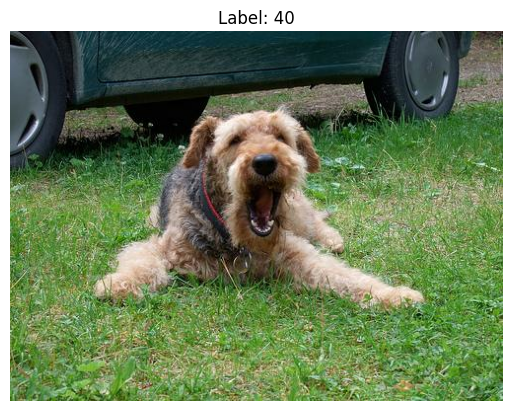

In [39]:
item = get_one(ds_test)

In [11]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있다고합니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타납니다
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

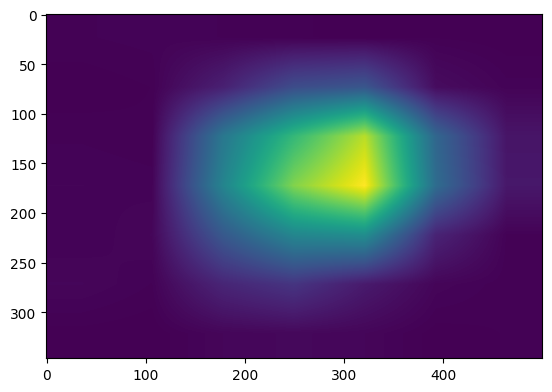

In [12]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [13]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

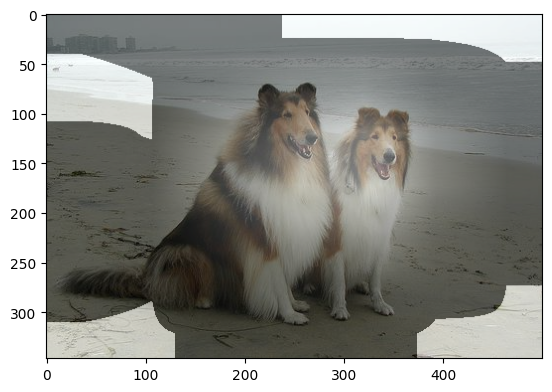

In [14]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM

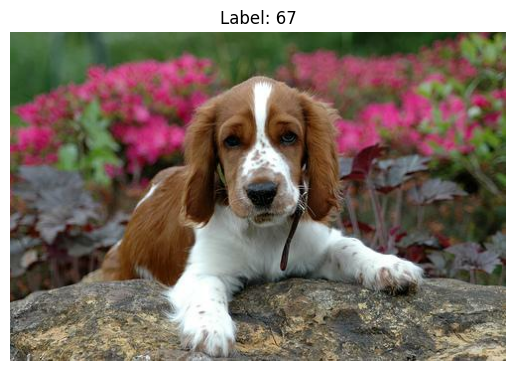

In [40]:
item = get_one(ds_test)

In [41]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

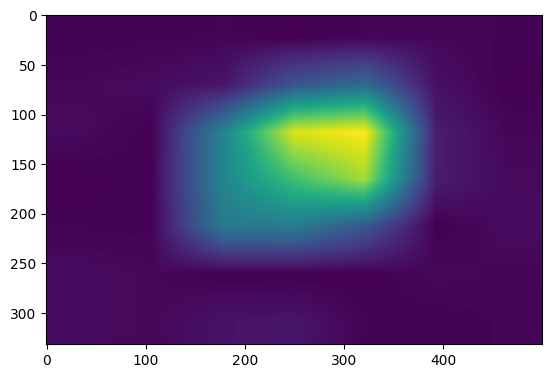

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

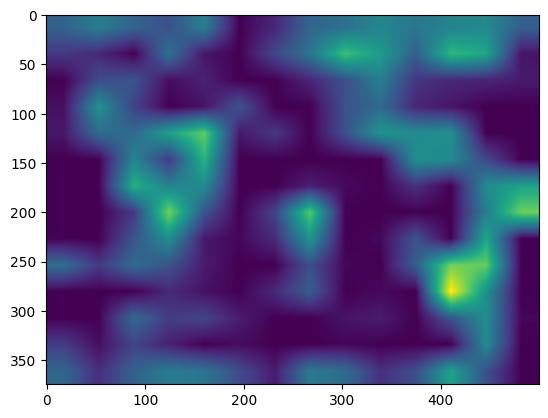

In [18]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

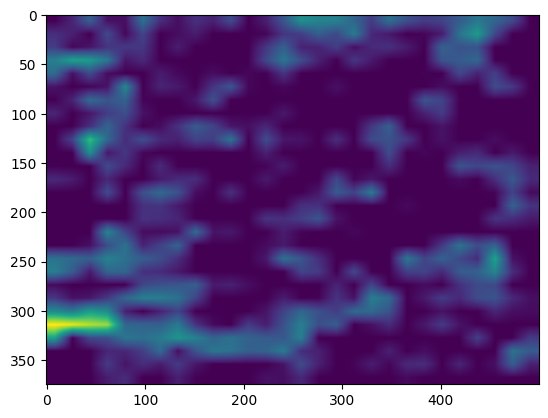

In [19]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### Detection with CAM

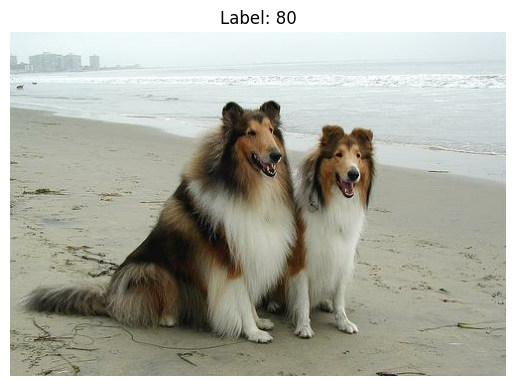

In [47]:
item = get_one(ds_test)

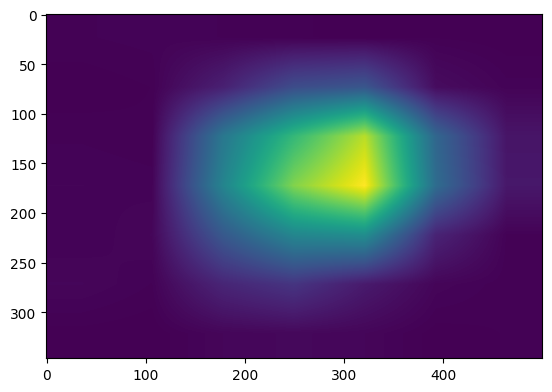

In [48]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [49]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [50]:
rect = get_bbox(cam_image)
rect

array([[ 63, 103],
       [417, -49],
       [524, 198],
       [170, 351]], dtype=int64)

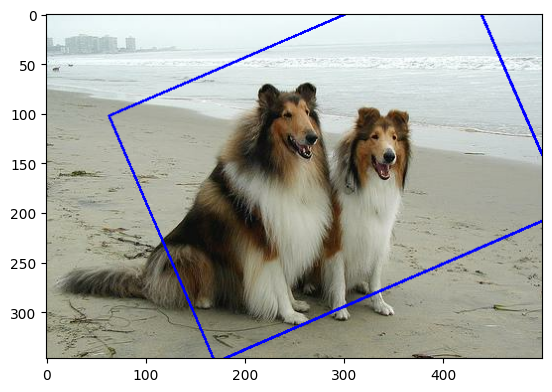

In [51]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [25]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [26]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.048, 0.066, 1.088, 0.938]

In [27]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [28]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [29]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3841742926142077

<br>

## 5. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 U-Net 모델과 U-Net++ 모델의 성능 비교를 수행하였습니다. 성능 비교를 위해 모델의 손실값과 IoU 값을 확인하였습니다. 모델 학습을 위해 KITTI 데이터셋을 사용하였습니다. 학습률 1e-4로 설정한 Adam 옵티마이저로 총 100회 학습하였습니다. 각 모델의 최저 손실값과 IoU 값을 비교한 결과, 두 수치 모두 U-Net++가 양호함을 확인하였습니다.
</span>

***

<br>

#### 형상관리 기록
***
+ v1_1: 초기 예제
***